In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pathlib import Path
import re

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Imports successful!")

✓ Imports successful!


In [2]:
# Define theme keywords for rule-based clustering
THEME_KEYWORDS = {
    'Account Access Issues': [
        'login', 'password', 'account', 'locked', 'access', 'sign in', 
        'authentication', 'verify', 'otp', 'code', 'unlock', 'reset'
    ],
    'Transaction Performance': [
        'transfer', 'transaction', 'slow', 'loading', 'payment', 'send money',
        'receive', 'delay', 'pending', 'processing', 'speed', 'fast', 'quick'
    ],
    'Technical Issues': [
        'crash', 'bug', 'error', 'freeze', 'not working', 'broken', 'issue',
        'problem', 'fail', 'glitch', 'stuck', 'down', 'offline'
    ],
    'User Interface & Experience': [
        'ui', 'interface', 'design', 'easy', 'simple', 'user friendly',
        'navigation', 'layout', 'look', 'beautiful', 'modern', 'clean'
    ],
    'Customer Support': [
        'support', 'help', 'customer service', 'call center', 'contact',
        'response', 'complaint', 'feedback', 'assist', 'service'
    ],
    'Feature Requests': [
        'need', 'want', 'add', 'feature', 'should', 'wish', 'request',
        'update', 'improve', 'enhancement', 'suggest', 'would be nice'
    ],
    'Security & Privacy': [
        'security', 'safe', 'secure', 'privacy', 'protect', 'fingerprint',
        'biometric', 'fraud', 'scam', 'trust', 'encryption'
    ]
}

print(f"Defined {len(THEME_KEYWORDS)} themes:")
for theme in THEME_KEYWORDS.keys():
    print(f"  • {theme}")

Defined 7 themes:
  • Account Access Issues
  • Transaction Performance
  • Technical Issues
  • User Interface & Experience
  • Customer Support
  • Feature Requests
  • Security & Privacy


In [3]:
def clean_text(text):
    """Clean and normalize text"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = ' '.join(text.split())
    return text

def assign_themes(text):
    """Assign themes based on keyword matching"""
    if pd.isna(text) or text == '':
        return []
    
    text_lower = str(text).lower()
    matched_themes = []
    
    for theme, keywords in THEME_KEYWORDS.items():
        for keyword in keywords:
            if keyword in text_lower:
                matched_themes.append(theme)
                break
    
    return matched_themes

print("✓ Functions defined")

✓ Functions defined


In [4]:
# Load data with sentiment
df = pd.read_csv('../data/reviews_with_sentiment.csv')

print(f"Loaded {len(df)} reviews")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Loaded 1800 reviews

Columns: ['review', 'rating', 'date', 'bank', 'source', 'sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'sentiment_score', 'sentiment_label']


,review,rating,date,bank,source,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_score,sentiment_label
0,maaliif daddafee install gaafata,3,2025-11-28,CBE,Google Play,0.000,0.0,1.000,0.0000,neutral
1,good app,5,2025-11-28,CBE,Google Play,0.744,0.0,0.256,0.4404,positive
2,This application is very important and advanta...,5,2025-11-27,CBE,Google Play,0.204,0.0,0.796,0.5198,positive
3,why didn't work this app?,1,2025-11-27,CBE,Google Play,0.000,0.0,1.000,0.0000,neutral
4,The app makes our life easier. Thank you CBE!,5,2025-11-27,CBE,Google Play,0.444,0.0,0.556,0.6800,positive


In [5]:
def extract_keywords_tfidf(reviews, n_keywords=15):
    """Extract top keywords using TF-IDF"""
    
    cleaned_reviews = [clean_text(r) for r in reviews]
    
    vectorizer = TfidfVectorizer(
        max_features=500,
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.8,
        stop_words='english'
    )
    
    try:
        tfidf_matrix = vectorizer.fit_transform(cleaned_reviews)
        feature_names = vectorizer.get_feature_names_out()
        avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
        
        top_indices = avg_scores.argsort()[-n_keywords:][::-1]
        top_keywords = [(feature_names[i], avg_scores[i]) for i in top_indices]
        
        return top_keywords
    except:
        return []

# Extract keywords for each bank
print("=== TOP KEYWORDS BY BANK ===\n")
bank_keywords = {}

for bank in df['bank'].unique():
    print(f"{bank}:")
    bank_reviews = df[df['bank'] == bank]['review'].tolist()
    keywords = extract_keywords_tfidf(bank_reviews, n_keywords=15)
    bank_keywords[bank] = keywords
    
    for keyword, score in keywords[:10]:
        print(f"  • {keyword}: {score:.4f}")
    print()

=== TOP KEYWORDS BY BANK ===

CBE:
  • good: 0.1538
  • app: 0.0792
  • best: 0.0523
  • nice: 0.0428
  • good app: 0.0280
  • excellent: 0.0258
  • ok: 0.0237
  • cbe: 0.0231
  • bank: 0.0216
  • application: 0.0158

BOA:
  • app: 0.0994
  • good: 0.0768
  • worst: 0.0358
  • update: 0.0313
  • best: 0.0275
  • slow: 0.0261
  • work: 0.0245
  • bank: 0.0235
  • time: 0.0234
  • mobile: 0.0227

Dashen:
  • app: 0.0906
  • good: 0.0808
  • best: 0.0495
  • nice: 0.0393
  • bank: 0.0318
  • dashen: 0.0314
  • super: 0.0281
  • wow: 0.0268
  • fast: 0.0242
  • banking: 0.0239



In [6]:
# Assign themes
print("Assigning themes to reviews...")
df['themes'] = df['review'].apply(assign_themes)
df['num_themes'] = df['themes'].apply(len)
df['theme_names'] = df['themes'].apply(lambda x: ', '.join(x) if x else 'No Theme')

print("✓ Theme assignment complete!\n")

print("=== THEME ANALYSIS SUMMARY ===")
print(f"Reviews with at least one theme: {(df['num_themes'] > 0).sum()} ({(df['num_themes'] > 0).sum() / len(df) * 100:.1f}%)")
print(f"Average themes per review: {df['num_themes'].mean():.2f}\n")

# Show sample
df[['review', 'rating', 'sentiment_label', 'theme_names']].head(10)

Assigning themes to reviews...
✓ Theme assignment complete!

=== THEME ANALYSIS SUMMARY ===
Reviews with at least one theme: 658 (36.6%)
Average themes per review: 0.64



,review,rating,sentiment_label,theme_names
0,maaliif daddafee install gaafata,3,neutral,Feature Requests
1,good app,5,positive,No Theme
2,This application is very important and advanta...,5,positive,Transaction Performance
3,why didn't work this app?,1,neutral,No Theme
4,The app makes our life easier. Thank you CBE!,5,positive,No Theme
5,this app very bad 👎,1,negative,No Theme
6,the most advanced app. but how to stay safe?,5,positive,Security & Privacy
7,Good application,4,positive,No Theme
8,It is nice app,5,positive,No Theme
9,best,5,positive,No Theme


In [7]:
print("=== THEME DISTRIBUTION BY BANK ===\n")

for bank in df['bank'].unique():
    print(f"{bank}:")
    bank_df = df[df['bank'] == bank]
    
    all_themes = []
    for themes in bank_df['themes']:
        all_themes.extend(themes)
    
    theme_counts = Counter(all_themes)
    for theme, count in theme_counts.most_common():
        percentage = (count / len(bank_df)) * 100
        print(f"  • {theme}: {count} ({percentage:.1f}%)")
    print()

=== THEME DISTRIBUTION BY BANK ===

CBE:
  • Feature Requests: 66 (11.0%)
  • Transaction Performance: 56 (9.3%)
  • Technical Issues: 34 (5.7%)
  • Account Access Issues: 30 (5.0%)
  • User Interface & Experience: 28 (4.7%)
  • Customer Support: 25 (4.2%)
  • Security & Privacy: 11 (1.8%)

BOA:
  • Feature Requests: 110 (18.3%)
  • Technical Issues: 85 (14.2%)
  • Transaction Performance: 78 (13.0%)
  • Account Access Issues: 70 (11.7%)
  • User Interface & Experience: 33 (5.5%)
  • Customer Support: 24 (4.0%)
  • Security & Privacy: 16 (2.7%)

Dashen:
  • Transaction Performance: 121 (20.2%)
  • User Interface & Experience: 102 (17.0%)
  • Feature Requests: 95 (15.8%)
  • Technical Issues: 44 (7.3%)
  • Customer Support: 43 (7.2%)
  • Account Access Issues: 38 (6.3%)
  • Security & Privacy: 34 (5.7%)



In [8]:
print("=== OVERALL THEME DISTRIBUTION ===\n")

all_themes = []
for themes in df['themes']:
    all_themes.extend(themes)

theme_counts = Counter(all_themes)

for theme, count in theme_counts.most_common():
    percentage = (count / len(df)) * 100
    print(f"{theme}: {count} ({percentage:.1f}%)")

=== OVERALL THEME DISTRIBUTION ===

Feature Requests: 271 (15.1%)
Transaction Performance: 255 (14.2%)
User Interface & Experience: 163 (9.1%)
Technical Issues: 163 (9.1%)
Account Access Issues: 138 (7.7%)
Customer Support: 92 (5.1%)
Security & Privacy: 61 (3.4%)


/tmp/ipykernel_4500/3275900683.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  theme_coverage = df.groupby('bank').apply(


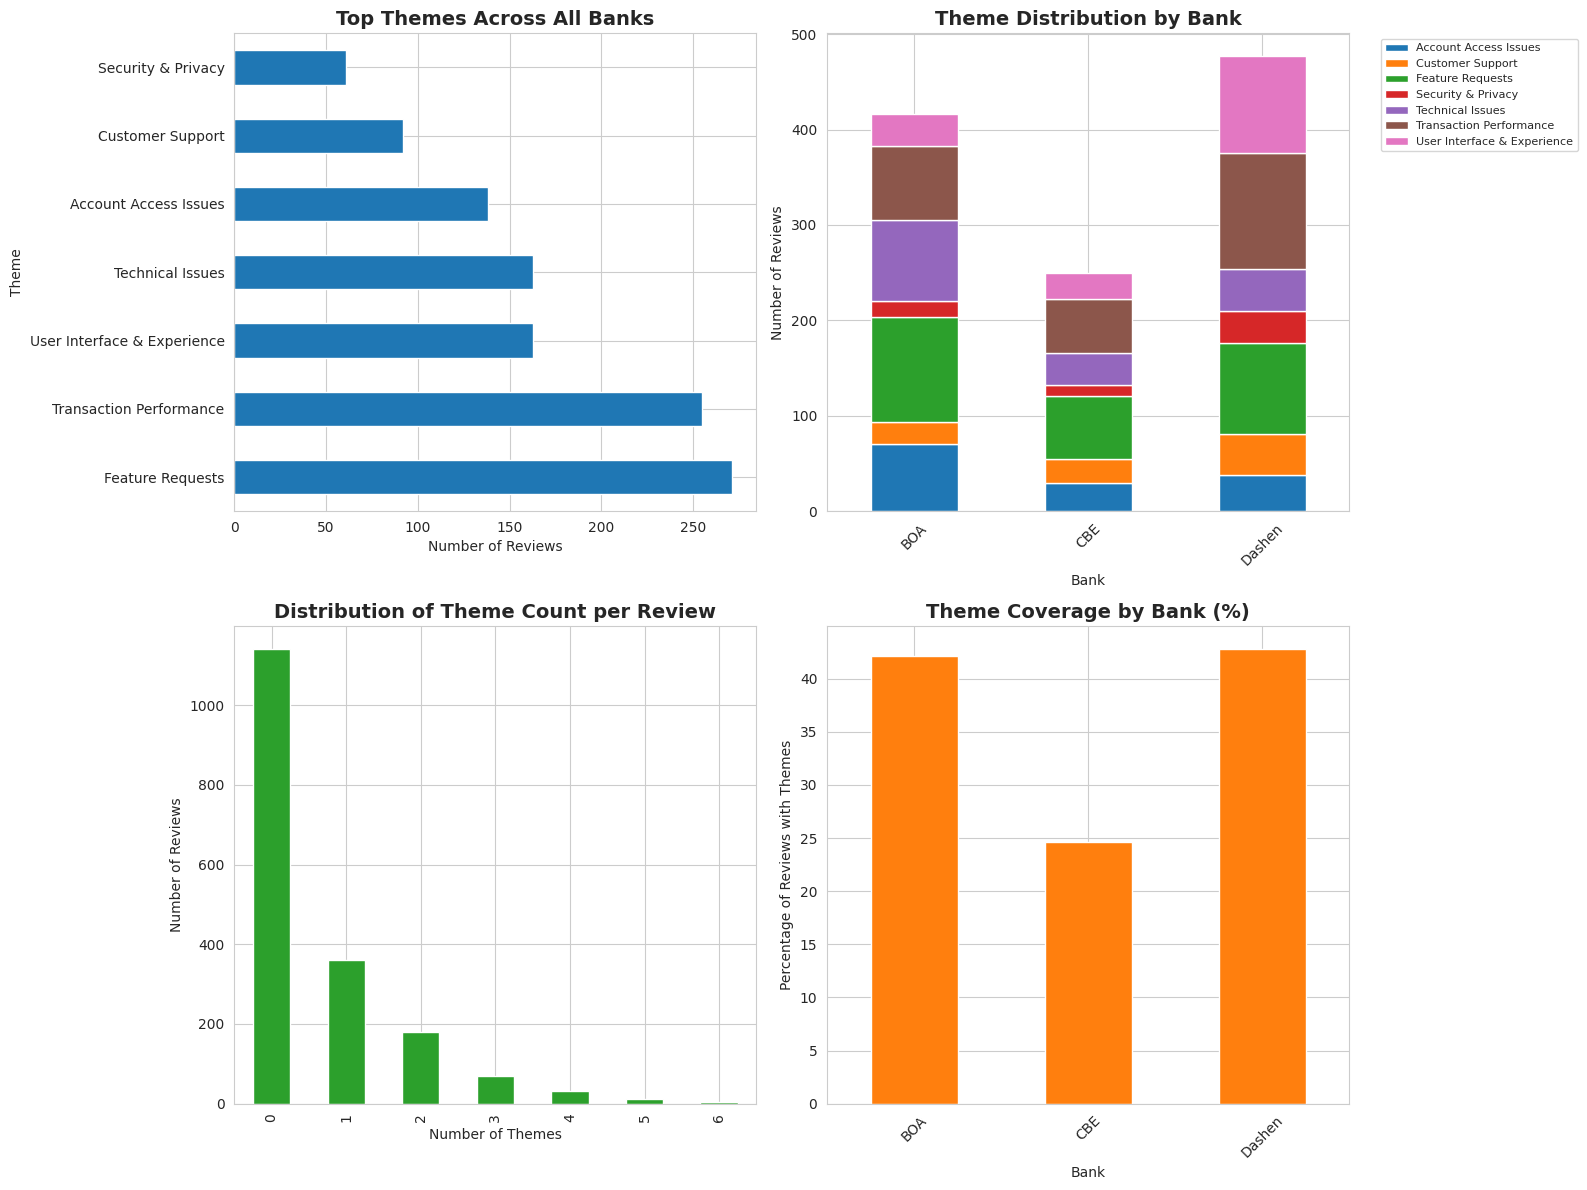

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top themes overall
all_themes = []
for themes in df['themes']:
    all_themes.extend(themes)

theme_counts = Counter(all_themes)
theme_df = pd.DataFrame(theme_counts.most_common(7), columns=['Theme', 'Count'])
theme_df.plot(x='Theme', y='Count', kind='barh', ax=axes[0, 0], 
             color='#1f77b4', legend=False)
axes[0, 0].set_title('Top Themes Across All Banks', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Reviews')
axes[0, 0].set_ylabel('Theme')

# 2. Themes by bank
theme_data = []
for bank in df['bank'].unique():
    bank_df = df[df['bank'] == bank]
    bank_themes = []
    for themes in bank_df['themes']:
        bank_themes.extend(themes)
    theme_counts = Counter(bank_themes)
    
    for theme, count in theme_counts.items():
        theme_data.append({'Bank': bank, 'Theme': theme, 'Count': count})

if theme_data:
    theme_pivot_df = pd.DataFrame(theme_data)
    theme_pivot = theme_pivot_df.pivot_table(index='Bank', columns='Theme', 
                                             values='Count', fill_value=0)
    theme_pivot.plot(kind='bar', stacked=True, ax=axes[0, 1])
    axes[0, 1].set_title('Theme Distribution by Bank', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Bank')
    axes[0, 1].set_ylabel('Number of Reviews')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Number of themes per review
df['num_themes'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0], 
                                                   color='#2ca02c')
axes[1, 0].set_title('Distribution of Theme Count per Review', 
                    fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Themes')
axes[1, 0].set_ylabel('Number of Reviews')

# 4. Theme coverage by bank
theme_coverage = df.groupby('bank').apply(
    lambda x: (x['num_themes'] > 0).sum() / len(x) * 100
)
theme_coverage.plot(kind='bar', ax=axes[1, 1], color='#ff7f0e')
axes[1, 1].set_title('Theme Coverage by Bank (%)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Bank')
axes[1, 1].set_ylabel('Percentage of Reviews with Themes')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()